# Bring Cluster

In [3]:
#%matplotlib widget
import os
from collections import Counter

import torch
import numpy as np
from joblib import dump, load

from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from bring_features_and_file_paths import bring_features_and_file_paths, transform_features 

## Bring all the features and file paths

In [8]:
# For Xeno-Canto
# features_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/xeno_canto_features'
# clusters_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/xeno_canto_clusters'
# include_indices_path = None
# label_predictions_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/xeno_canto_indices/label_predictions.pth'
# indices_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/xeno_canto_indices/indices.pth'

# For Morton Arboretum
features_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/features_third_pass'
clusters_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/clusters_third_pass'
include_indices_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/indices_third_pass/include_indices.pth'
label_predictions_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/indices_third_pass/label_predictions.pth'
indices_path = '/projects/MultiActiveAI/Samir_VICReg_Outputs/indices_third_pass/indices.pth'

In [9]:
features, file_paths = bring_features_and_file_paths(features_path)

We have 2136286 feature vectors.


Now, we want to transform the features, scaling them and reducing their dimensionality

In [10]:
dim_red_model = load(os.path.join(clusters_path, 'dim_red_model'))
scale_model = load(os.path.join(clusters_path, 'scale_model'))

In [11]:
print('We have {} feature vectors before removing indices.' .format(features.shape[0]))
 
# exclude_indices = set(torch.load("/projects/MultiActiveAI/Samir_VICReg_Outputs/indices_first_pass/indices.pth"))
# include_indices = [i for i in range(len(features)) if i not in exclude_indices]

if include_indices_path is not None:
    include_indices = torch.load(include_indices_path)
    indices = include_indices
    features = features[include_indices]
    file_paths = file_paths[include_indices]
else:
    indices = torch.tensor(range(len(features)))
    
print('We have {} feature vectors after removing indices.' .format(features.shape[0]))

samples = transform_features(features, scale_model, dim_red_model)

We have 2136286 feature vectors before removing indices.
We have 212417 feature vectors after removing indices.


Load the clusters generated from the features

We will use them to classify our sample of features now

In [12]:
clusters = np.load(os.path.join(clusters_path, 'clusters.npy'), allow_pickle=True)
vectors = clusters[()]['x']
labels = clusters[()]['y']

In [13]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 40
Estimated number of noise points: 0


Train a k-nearest neighbor algorithm to predict the samples

In [14]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(vectors, labels)
label_predictions = neigh.predict(samples)

In [15]:
# torch.save(indices, indices_path)
torch.save(label_predictions, label_predictions_path)

In [16]:
label_predictions = torch.load(label_predictions_path)

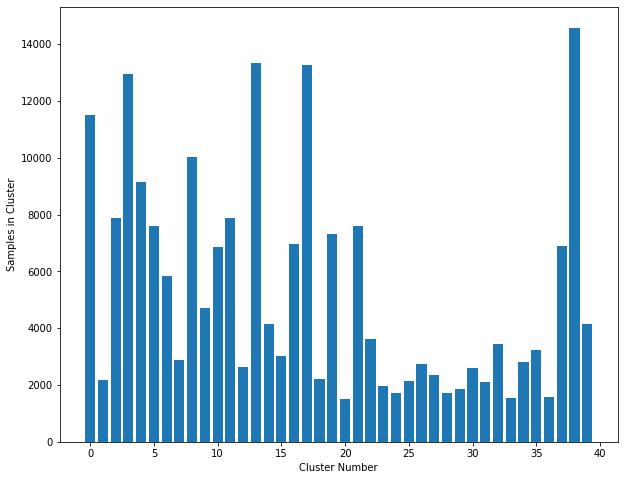

In [17]:
cluster_counts = np.array(sorted(Counter(label_predictions).items()))
fig, ax = plt.subplots(figsize=(10, 8))
plt.bar(cluster_counts[:, 0], cluster_counts[:, 1])
ax.set_xlabel("Cluster Number")
ax.set_ylabel("Samples in Cluster")
plt.show()

## Analyze a Particular Cluster

In [18]:
core_samples = np.zeros_like(label_predictions, dtype=bool)
cluster_number = 5
core_samples[label_predictions == cluster_number] = True
n_noise_points = list(label_predictions).count(-1)

In [19]:
cluster_samples = samples[core_samples]

In [20]:
def choose_random_rows(an_array, n_samples):
    number_of_rows = an_array.shape[0]
    random_indices = np.random.choice(number_of_rows, size=n_samples, replace=False)
    random_rows = an_array[random_indices, :]
    return random_rows

X = choose_random_rows(vectors, 5000)
n_components = X.shape[1]

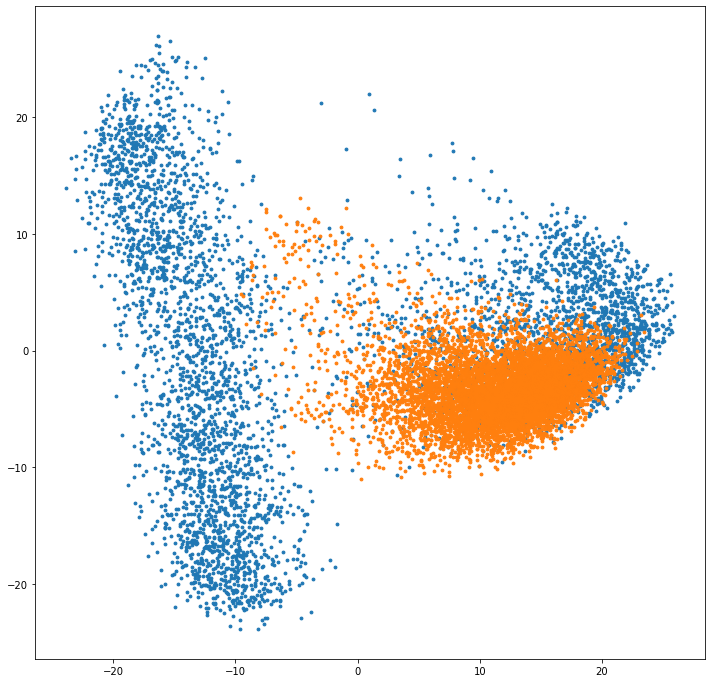

In [21]:
n_components = 2
if n_components == 2:
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot()
    ax.scatter(X[:,0],X[:,1],s=8)
    ax.scatter(cluster_samples[:,0],
               cluster_samples[:,1],
               s=8
              )
elif n_components == 3:
    fig = plt.figure(figsize=(8,8))
    #ax = fig.add_subplot(projection='3d')
    ax = Axes3D(fig)
    ax.scatter(X[:,0], X[:,1], X[:,2])
    ax.scatter(
        cluster_samples[:,0],
        cluster_samples[:,1],
        cluster_samples[:,2],
        s=60
    )